In [15]:
import scanpy
import numpy as np
import matplotlib
import phate
from sklearn import linear_model, model_selection
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scprep

In [2]:
data = scanpy.read_h5ad('./data/processed_data.h5ad')
patient_label = data.obs[['patient','response']].drop_duplicates().set_index('patient').to_dict()['response']
patient_label = dict(zip(patient_label.keys(), (np.array(list(patient_label.values())) == 'R').astype(int)))
y = np.array([patient_label[x] for x in np.unique(data.obs['patient'])])

In [3]:
colors = {'mustard': '#E1AD01', 'berry': '#AC2F3D', 'teal': '#216E76', 'purple':'#502A4F', 
          'forest': '#065535', 'light forest': '#519167',
          'light yellow': '#E3BC81', 'light berry': '#c7505d', 'light gray': 'lightgray',
          'light teal': '#81ABA1', 'light purple': '#95636E', 'black': '#000000'}
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('',["black",colors["light berry"]])

In [4]:
pt_features = np.load(f'results/GSPA_QR_gene.npy').reshape(48,-1)
phate_op = phate.PHATE(verbose=True, random_state=42)
data_phate = phate_op.fit_transform(pt_features)

Calculating PHATE...
  Running PHATE on 48 observations and 61820 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.18 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.19 seconds.
  Calculating optimal t...
    Automatically selected t = 19
  Calculated optimal t in 0.01 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/graphtools/graphs.py:122: UserWarning: Building a kNNGraph on data of shape (48, 61820) is expensive. Consider setting n_pca.
  warnings.warn(


Calculated PHATE in 0.21 seconds.


## Predictive genes

In [8]:
coefs = []
for i in range(100):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(pt_features,
                                                                        y,
                                                                        test_size=0.5, random_state=i)
    clf = linear_model.RidgeClassifier()
    clf.fit(X_train, y_train)
    y_bin = clf.predict(X_test)
    
    coefs.append(clf.coef_)
coefs = np.vstack(np.array(coefs)).mean(axis=0)
coefs = list(zip(np.hstack(np.array([[x+f'_{i}' for i in range(5)] for x in data.var_names])), coefs))
g = [x[0] for x in coefs]
v = [x[1] for x in coefs]
df = pd.DataFrame((g, v)).T.sort_values(by=1)
df = df.set_index(0)

/tmp/ipykernel_1711751/532402220.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df[:N].index, orient='h', x=df[:N][1], palette=cmap(range(N)))
/tmp/ipykernel_1711751/532402220.py:5: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(y=df[:N].index, orient='h', x=df[:N][1], palette=cmap(range(N)))
/tmp/ipykernel_1711751/532402220.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=df[-N:][::-1].index, orient='h', x=df[-N:][::-1][1], palette=cmap(range(N)), )
/tmp/ipykernel_1711751/532402220.py:14: UserWarning: Numpy array is not a supported type for `palette`. Please convert your p

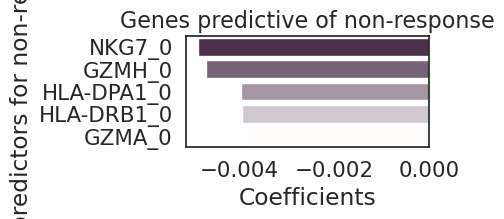

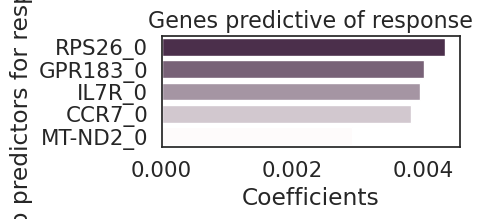

In [13]:
N = 5
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('',[colors['purple'], 'snow'], N=N)
sns.set(font_scale=1.4, style='white')
fig = plt.figure(figsize=(5,2.5*(N/5)))
sns.barplot(y=df[:N].index, orient='h', x=df[:N][1], palette=cmap(range(N)))
plt.ylabel('Top predictors for non-response')
plt.xlabel('Coefficients')
plt.title('Genes predictive of non-response', fontsize=16)
plt.tight_layout()
fig.savefig('figures/genes_non-response.png', dpi=200)


fig = plt.figure(figsize=(5,2.5*(N/5)))
sns.barplot(y=df[-N:][::-1].index, orient='h', x=df[-N:][::-1][1], palette=cmap(range(N)), )
plt.ylabel('Top predictors for response')
plt.xlabel('Coefficients')
plt.title('Genes predictive of response', fontsize=16)
plt.tight_layout()
fig.savefig('figures/genes_response.png', dpi=200)

## Other pt visualization

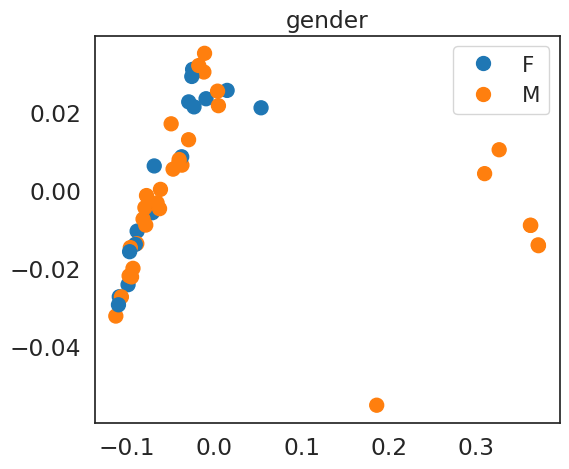

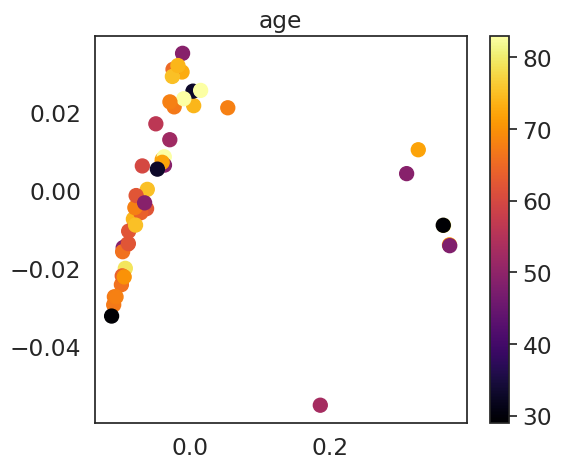

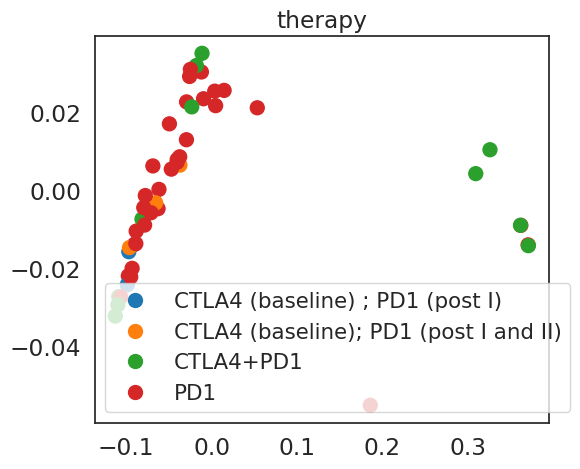

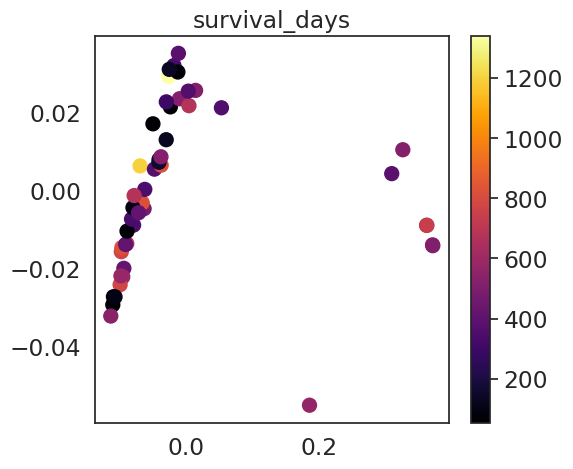

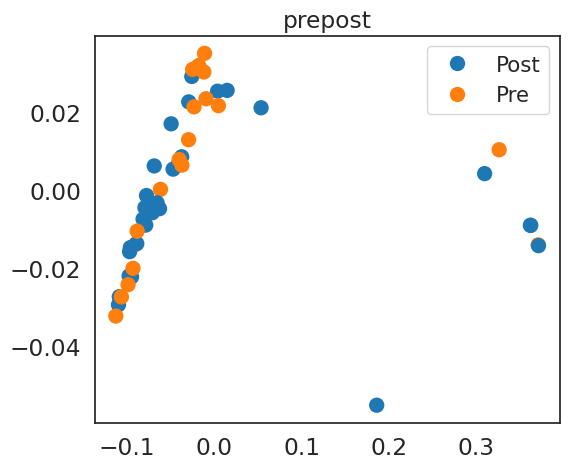

In [16]:
for obs in ['gender', 'age', 'therapy','survival_days', 'prepost']:
    pt = data.obs.set_index('patient').loc[np.unique(data.obs['patient'])][[obs]].reset_index().drop_duplicates()
    if obs in ['age', 'survival_days']:
        discrete=False
        color = pt[obs].astype(int)
    else:
        discrete=True
        color = pt[obs]
    
    scprep.plot.scatter2d(data_phate, c=color, figsize=(6,5), dpi=200, s=100, title=obs, discrete=discrete)

## Patient proportions

In [16]:
patient_proportions = pd.DataFrame(index=np.unique(data.obs['patient']), columns=np.unique(data.obs['cluster_all']))
for patient in np.unique(data.obs['patient']):
    pat = data[data.obs['patient'] == patient]
    pat_prop = pat.obs['cluster_all'].value_counts() / pat.n_obs
    patient_proportions.loc[patient] = pat_prop

patient_proportions.fillna(0, inplace=True)

In [17]:
patient_proportions = patient_proportions* 100

<Axes: >

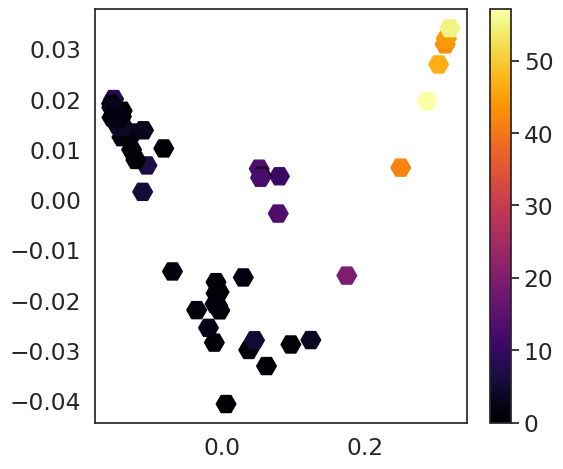

In [18]:
scprep.plot.scatter2d(data_phate, c=patient_proportions['G01'], figsize=(6,5),
                      dpi=200, filename='figures/B_cells.png', s=200, marker='H')

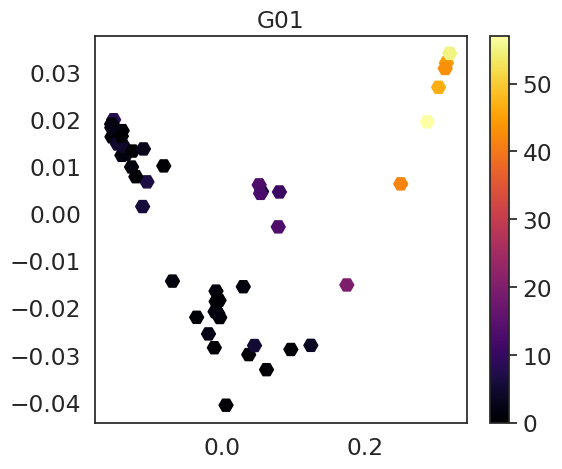

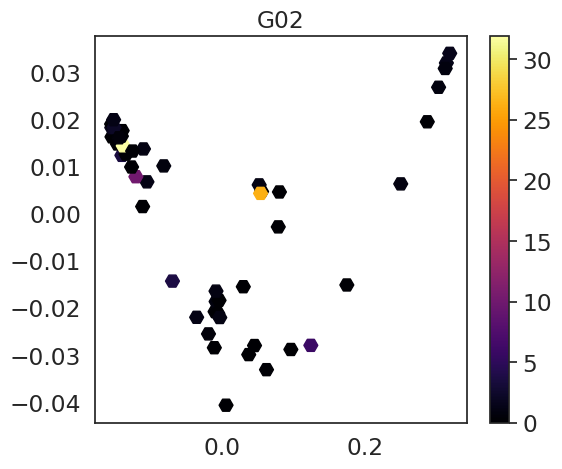

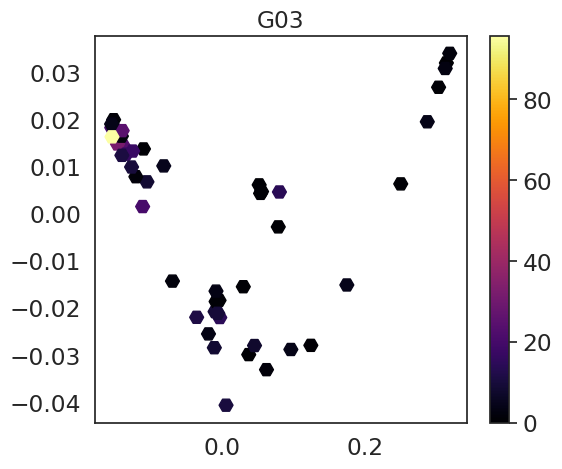

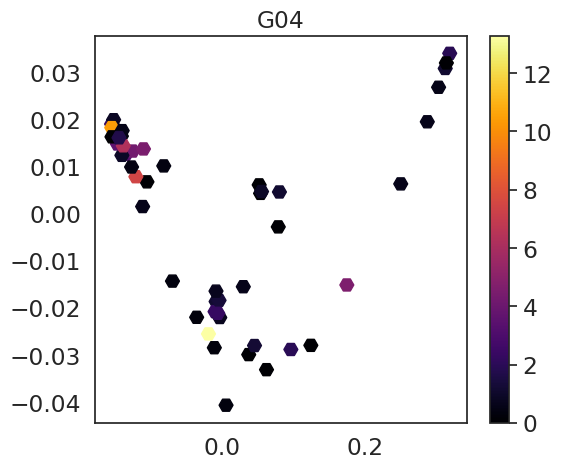

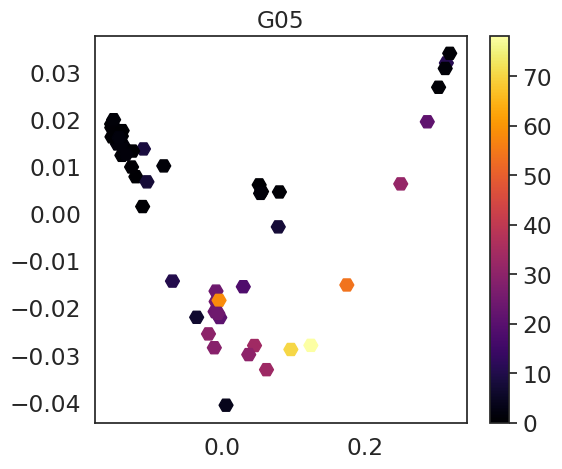

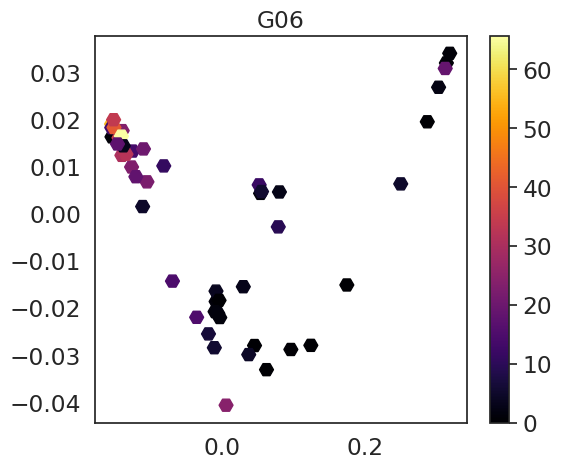

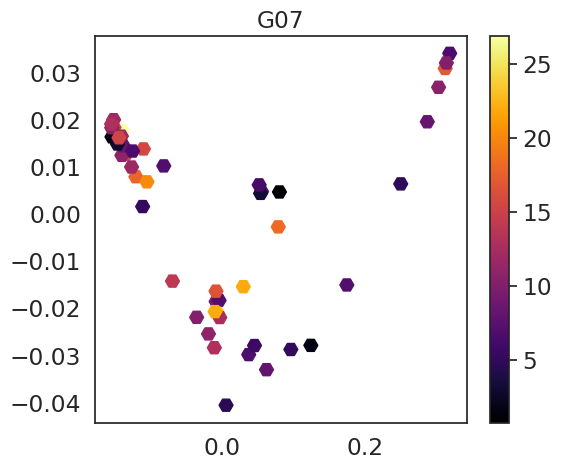

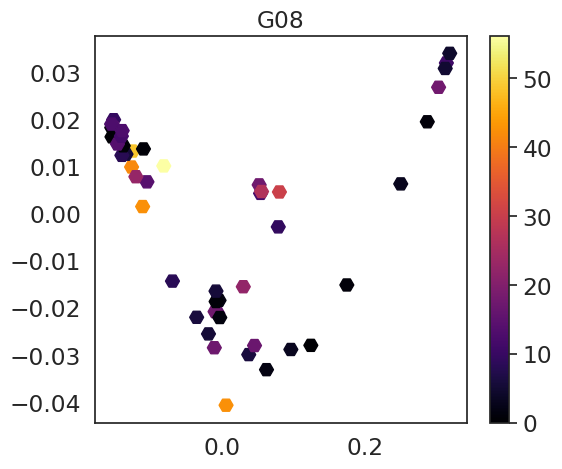

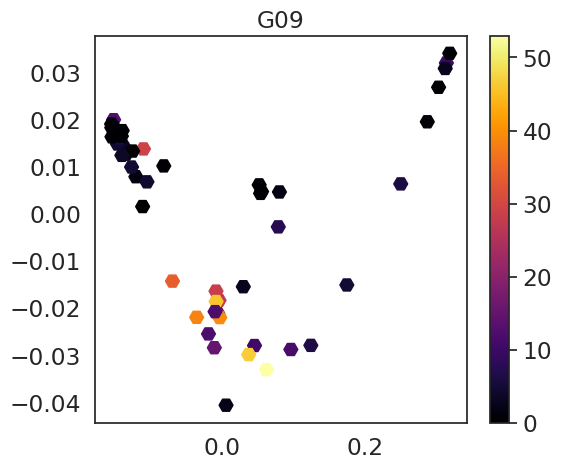

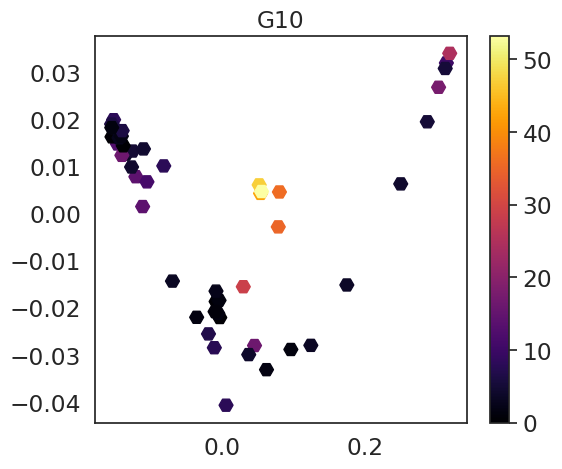

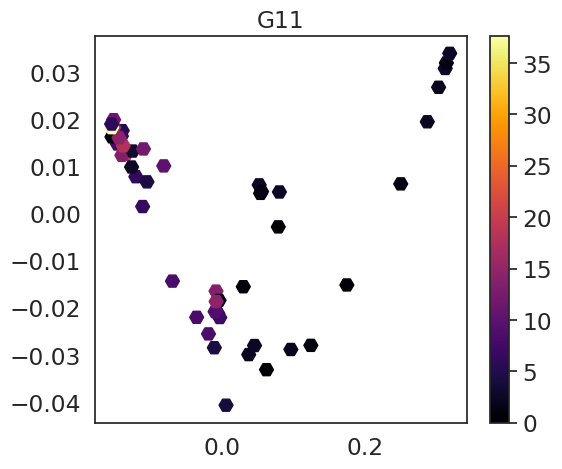

In [19]:
for cell_type in patient_proportions.columns:
    scprep.plot.scatter2d(data_phate, c=patient_proportions[cell_type], figsize=(6,5),
                      dpi=200, filename=f'figures/{cell_type}.png', s=100, title=cell_type, marker='H')

##  Patient trajectories

In [17]:
patient_trajectories = {'P1':['Pre_P1', 'Post_P1', 'Post_P1_2'],
'P3':['Pre_P3', 'Post_P3', 'Post_P3_2'],
'P20':['Pre_P20','Post_P20']
}

In [18]:
col = ['light gray', 'light forest', 'forest']

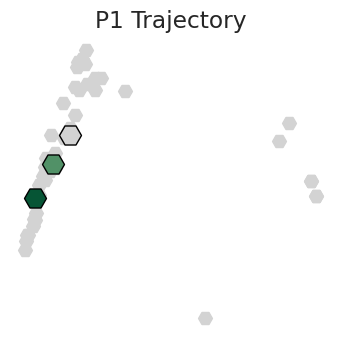

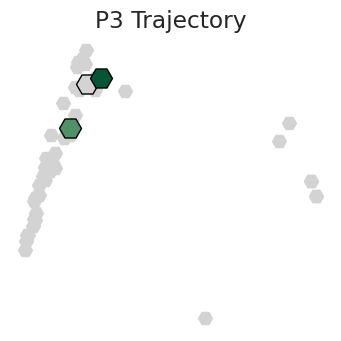

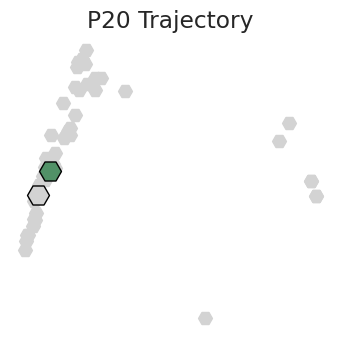

In [19]:
for pt, trajectory in patient_trajectories.items():
    fig, ax = plt.subplots(figsize=(4,4))
    scprep.plot.scatter2d(data_phate, c='lightgray', ax=ax, s=100, marker='H')
    for i,samp in enumerate(trajectory):
        scprep.plot.scatter2d(data_phate[np.unique(data.obs['patient']) == samp], ticks=None, c=colors[col[i]], label=samp,
                              label_prefix='Patient PHATE', title=f'{pt} Trajectory', s=250, edgecolor='black', ax=ax, marker='H')
    #plt.legend()
    plt.tight_layout()
    plt.axis('off')
    fig.savefig(f'figures/{pt}_trajectory.png', dpi=200)

## P1

In [20]:
p = data[(data.obs['patient'] == 'Pre_P1') & (data.obs['isCD8'])].obs['cluster_cd8'].value_counts() 
print (p.sum())
print(p.loc[['4', '6']].sum() / p.sum())
print(p.loc[['1', '2']].sum() / p.sum())

126
0.5476190476190477
0.4523809523809524


In [21]:
p = data[(data.obs['patient'] == 'Post_P1') & (data.obs['isCD8'])].obs['cluster_cd8'].value_counts()
print (p.sum())
print(p.loc[['4', '5', '6']].sum() / p.sum())
print(p.loc[['1', '2', '3']].sum() / p.sum())

143
0.3706293706293706
0.6293706293706294


In [22]:
p = data[(data.obs['patient'] == 'Post_P1_2') & (data.obs['isCD8'])].obs['cluster_cd8'].value_counts()
print (p.sum())
print(p.loc[['4', '5', '6']].sum() / p.sum())
print(p.loc[['1', '2', '3']].sum() / p.sum())

193
0.3316062176165803
0.6683937823834197


## P20

In [23]:
p = data[(data.obs['patient'] == 'Pre_P20') & (data.obs['isCD8'])].obs['cluster_cd8'].value_counts()
print (p.sum())
print(p.loc[['4', '5', '6']].sum() / p.sum())
print(p.loc[['1', '2', '3']].sum() / p.sum())

174
0.20689655172413793
0.7931034482758621


In [24]:
p = data[(data.obs['patient'] == 'Post_P20') & (data.obs['isCD8'])].obs['cluster_cd8'].value_counts()
print (p.sum())
print(p.loc[['4', '5', '6']].sum() / p.sum())
print(p.loc[['1', '2', '3']].sum() / p.sum())

102
0.30392156862745096
0.696078431372549


## P3

In [25]:
p = data[(data.obs['patient'] == 'Pre_P3') & (data.obs['isCD8'])].obs['cluster_cd8'].value_counts() 
print (p.sum())
print(p.loc[['4', '6']].sum() / p.sum())
print(p.loc[['1', '2']].sum() / p.sum())

95
0.8
0.17894736842105263


In [26]:
p = data[(data.obs['patient'] == 'Post_P3') & (data.obs['isCD8'])].obs['cluster_cd8'].value_counts()
print (p.sum())
print(p.loc[['4', '5', '6']].sum() / p.sum())
print(p.loc[['1', '2', '3']].sum() / p.sum())

152
0.6842105263157895
0.3157894736842105


In [27]:
p = data[(data.obs['patient'] == 'Post_P3_2') & (data.obs['isCD8'])].obs['cluster_cd8'].value_counts()
print (p.sum())
print(p.loc[['4', '5', '6']].sum() / p.sum())
print(p.loc[['1', '2', '3']].sum() / p.sum())

225
0.9066666666666666
0.09333333333333334
